In [1]:
# ref: https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition/input
import sys
import os

import numpy as np
import pandas as pd
from glob import glob

import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall

import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [2]:
PATH_RAVDESS = "./raw_data/RAVDESS/"
PATH_CREMA = "./raw_data/CREMA-D/"
PATH_TESS = "./raw_data/TESS/"
PATH_SAVEE = "./raw_data/SAVEE/"

RANDOM_STATE = 11

## Bug
* [display waveshow error](https://github.com/matplotlib/matplotlib/issues/25506)

# Load Data

### 1. RAVDESS
Filename identifiers
* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01= neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disguest, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

<p>Filename example: 03-01-06-01-02-01-12.wav</p>


In [3]:
ls_ravdess = glob(PATH_RAVDESS + 'Actor_0*/*')
ls_tmp = []
for fpath in ls_ravdess:
    fname = fpath.split('/')[-1].split('.')[0]
    modality, vocal_channel, emotion, emotional_intensity, statement, repetition, actor = [int(feat) for feat in fname.split('-')]
    ls_tmp.append([modality, vocal_channel, emotion, emotional_intensity, statement, repetition, actor, fpath])

df_ravdess = pd.DataFrame(ls_tmp, columns=['modality', 'vocal_channel', 'emotion', 'emotional_intensity', 'statetment', 'repetition', 'actor', 'fpath'])
dict_emotion_RAVDESS = {1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fearful', 7: 'disguest', 8: 'surprised'}
df_ravdess['emotion'] = df_ravdess['emotion'].replace(dict_emotion_RAVDESS)
print('RAVDESS shape: ', df_ravdess.shape)
df_ravdess.head(3)

RAVDESS shape:  (540, 8)


,modality,vocal_channel,emotion,emotional_intensity,statetment,repetition,actor,fpath
0,3,1,neutral,1,2,2,3,./raw_data/RAVDESS/Actor_03/03-01-01-01-02-02-...
1,3,1,happy,1,1,1,3,./raw_data/RAVDESS/Actor_03/03-01-03-01-01-01-...
2,3,1,angry,1,1,1,3,./raw_data/RAVDESS/Actor_03/03-01-05-01-01-01-...


## Explore Data Analysis

In [4]:
def create_waveplot(data, sample_rate, emotino):
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.set_title(f"Waveplot for audio with {emotion}.")
    librosa.display.waveshow(data, sr=sample_rate, ax=ax)

def create_spectrogram(data, sample_rate, emotion):
    fig, ax = plt.subplots(figsize=(6, 4))
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    ax.set_title(f'Spectrogram for audio with {emotion}')
    librosa.display.specshow(Xdb, sr=sample_rate, ax=ax, x_axis='time', y_axis='hz')

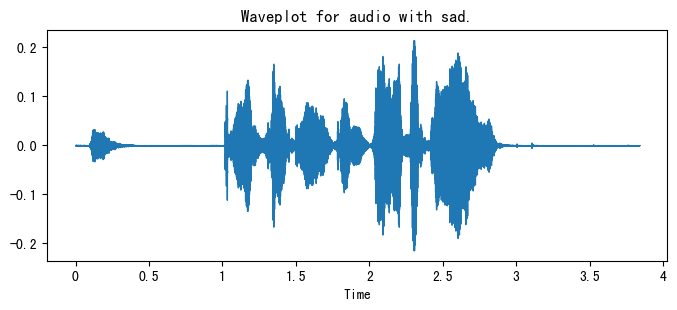

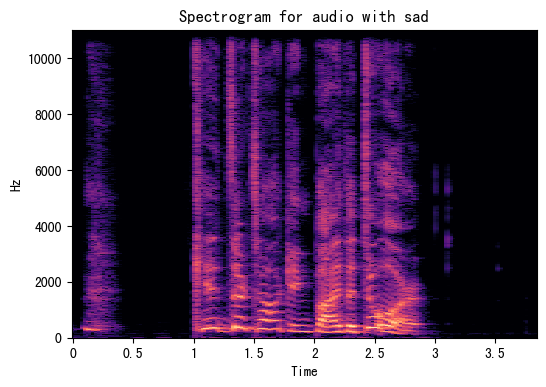

In [6]:
emotion = 'sad'
fpath = df_ravdess.loc[df_ravdess['emotion']==emotion, 'fpath'].iloc[0,]
data, sample_rate = librosa.load(fpath)
create_waveplot(data, sample_rate, emotion)
create_spectrogram(data, sample_rate, emotion)
Audio(fpath)

## Data Augmentation

In [7]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.max(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, n_steps=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=n_steps)

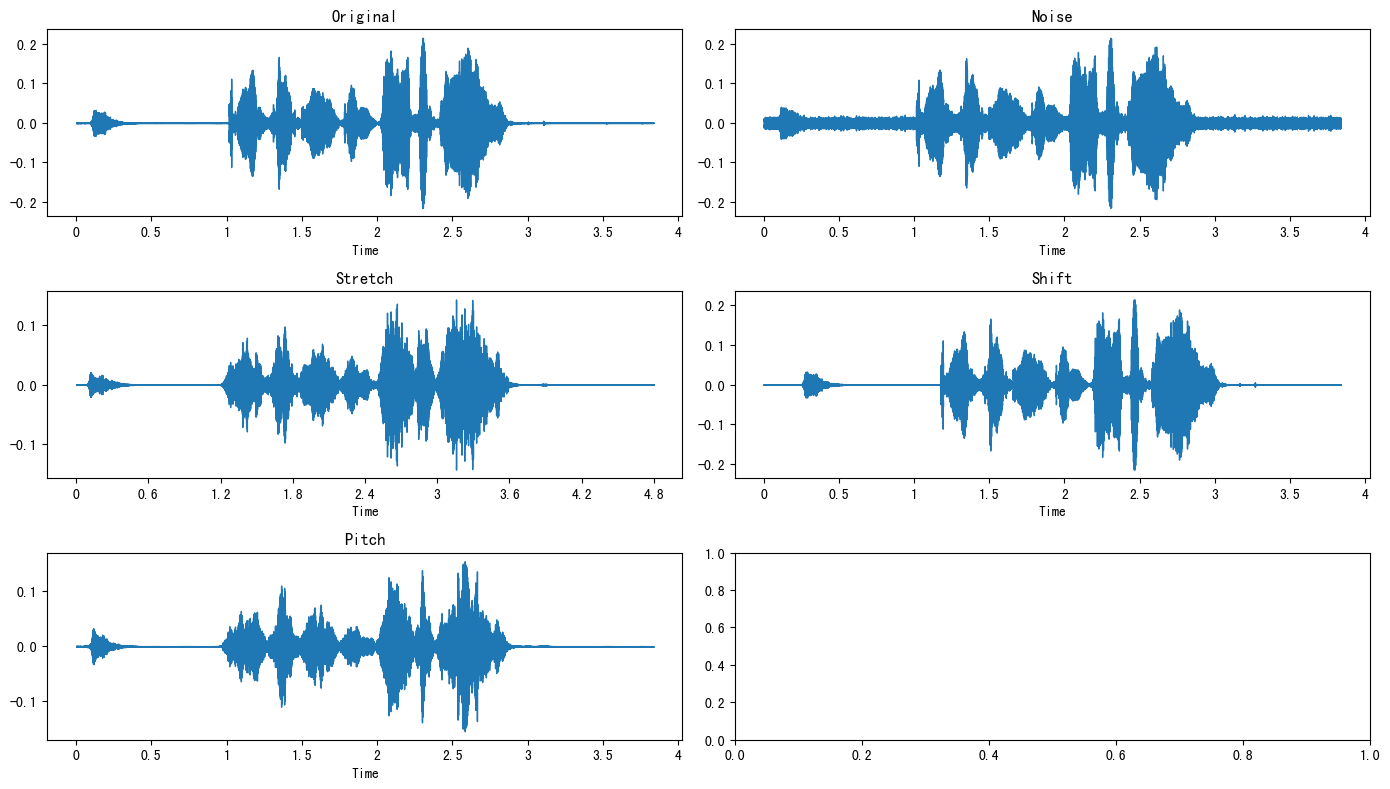

In [8]:
data_noise = noise(data)
data_stretch = stretch(data)
data_shift = shift(data)
data_pitch = pitch(data, sample_rate)

fig, axes = plt.subplots(3, 2, figsize=(14, 8))
axes[0][0].set_title('Original')
librosa.display.waveshow(y=data, sr=sample_rate, ax=axes[0][0])

axes[0][1].set_title('Noise')
librosa.display.waveshow(y=data_noise, sr=sample_rate, ax=axes[0][1])

axes[1][0].set_title('Stretch')
librosa.display.waveshow(y=data_stretch, sr=sample_rate, ax=axes[1][0])

axes[1][1].set_title('Shift')
librosa.display.waveshow(y=data_shift, sr=sample_rate, ax=axes[1][1])

axes[2][0].set_title('Pitch')
librosa.display.waveshow(y=data_pitch, sr=sample_rate, ax=axes[2][0])


plt.tight_layout()

## Feature Extraction

In [9]:
def extract_features(data):
    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    
    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stf = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)

    result = np.hstack((zcr, chroma_stf, mfcc, rms, mel))
    return result

def get_features(path):
    result = np.array([])

    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    data_noise = noise(data)
    data_stretch = stretch(data)
    data_stretch_pitch = pitch(data_stretch, sample_rate)

    result = np.vstack((
        extract_features(data),
        extract_features(data_noise),
        extract_features(data_stretch_pitch)
    ))
    return result

In [10]:
ls_features = []
for i, row in df_ravdess.iterrows():
    features = get_features(row['fpath'])
    for feat in features:
        ls_features.append(list(feat) + [row['emotion']])

df_ravdess_feat = pd.DataFrame(ls_features)
df_ravdess_feat = df_ravdess_feat.rename(columns={len(df_ravdess_feat.columns)-1: 'label'})
print(df_ravdess_feat.shape)
df_ravdess_feat.to_csv('./features/ravdess_deat.csv', index=False)
df_ravdess_feat.head(3)

(1620, 163)


,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,label
0,0.233941,0.654394,0.696817,0.715150,0.775305,0.687555,0.627232,0.607429,0.617372,0.620083,...,0.000426,0.000492,0.000554,0.000375,0.000416,0.000356,0.000391,0.000305,0.000026,neutral
1,0.305194,0.690659,0.723610,0.757454,0.831156,0.774450,0.702301,0.645766,0.662110,0.646848,...,0.000532,0.000573,0.000636,0.000453,0.000496,0.000429,0.000482,0.000400,0.000112,neutral
2,0.187551,0.673592,0.709256,0.707411,0.766522,0.647569,0.637203,0.633877,0.614532,0.619164,...,0.000051,0.000069,0.000114,0.000130,0.000096,0.000077,0.000109,0.000048,0.000004,neutral


## Data Preprocessing

In [44]:
X = df_ravdess_feat.iloc[:, :-1].values
y = df_ravdess_feat['label'].values

In [45]:
oh_encoder = OneHotEncoder()
y = oh_encoder.fit_transform(y.reshape(-1, 1)).toarray()

In [46]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.7, random_state=RANDOM_STATE)
print(f"{'Train X Shape':<15}: {train_X.shape}")
print(f"{'Train y Shape':<15}: {train_y.shape}")

print(f"{'Test X Shape':<15}: {test_X.shape}")
print(f"{'Test y Shape':<15}: {test_y.shape}")

Train X Shape  : (1134, 162)
Train y Shape  : (1134, 8)
Test X Shape   : (486, 162)
Test y Shape   : (486, 8)


In [47]:
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

train_X = np.expand_dims(train_X, axis=2)
test_X = np.expand_dims(test_X, axis=2)

## Model

In [48]:
BATCH_SIZE = 64
EPOCHS = 50
LR = 1e-4

In [49]:
def get_SER_model():
    model = Sequential()
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(train_X.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(units=8, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(lr=LR)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

    print(model.summary())

    return model

model = get_SER_model()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 81, 256)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 41, 128)           163968    
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 21, 128)         

In [50]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=1e-7)
history = model.fit(train_X, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_X, test_y), callbacks=[rlrp])

Epoch 1/50
18/18 [==============================] - 3s 31ms/step - loss: 2.0261 - accuracy: 0.1667 - precision_2: 0.6667 - recall_2: 0.0247 - val_loss: 1.9577 - val_accuracy: 0.1893 - val_precision_2: 0.7222 - val_recall_2: 0.0267 - lr: 0.0010
Epoch 2/50
18/18 [==============================] - 0s 16ms/step - loss: 1.9887 - accuracy: 0.1781 - precision_2: 0.6538 - recall_2: 0.0300 - val_loss: 1.9287 - val_accuracy: 0.2140 - val_precision_2: 0.8261 - val_recall_2: 0.0391 - lr: 0.0010
Epoch 3/50
18/18 [==============================] - 0s 15ms/step - loss: 1.9544 - accuracy: 0.2196 - precision_2: 0.6984 - recall_2: 0.0388 - val_loss: 1.9010 - val_accuracy: 0.2572 - val_precision_2: 0.7600 - val_recall_2: 0.0391 - lr: 0.0010
Epoch 4/50
18/18 [==============================] - 0s 15ms/step - loss: 1.9350 - accuracy: 0.2390 - precision_2: 0.6833 - recall_2: 0.0362 - val_loss: 1.8767 - val_accuracy: 0.2490 - val_precision_2: 0.7917 - val_recall_2: 0.0391 - lr: 0.0010
Epoch 5/50
18/18 [======

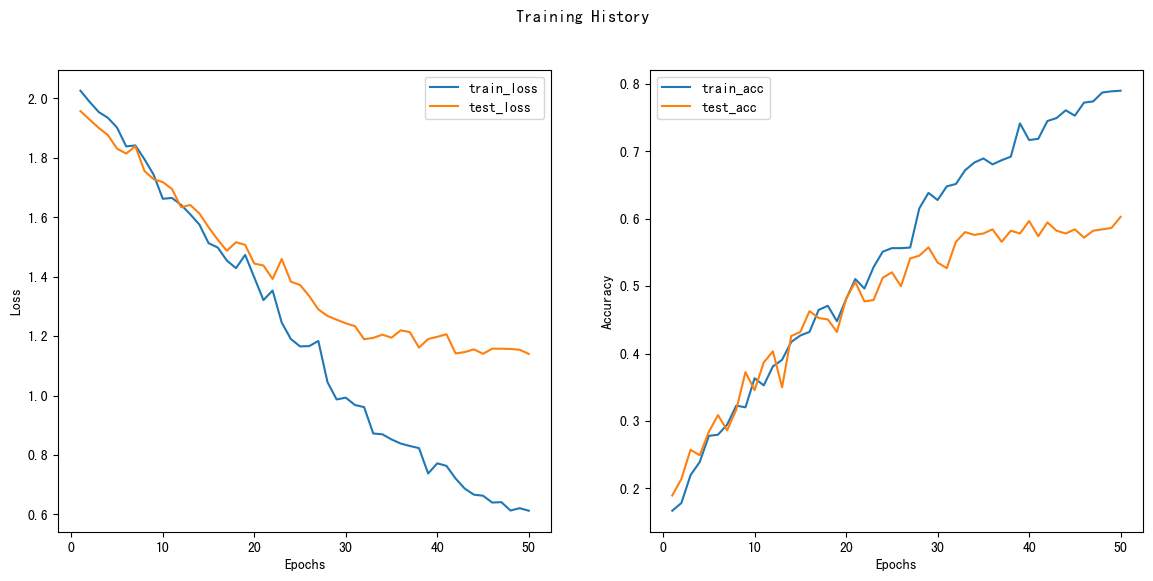

In [79]:
history.history.keys()
def plot_loss(history):
    history = history.history
    train_loss, train_acc = history['loss'], history['accuracy']
    test_loss, test_acc = history['val_loss'], history['val_accuracy']
    epoch = list(range(1, EPOCHS+1))

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    plt.suptitle('Training History')
    axes[0].plot(epoch, train_loss, label='train_loss')
    axes[0].plot(epoch, test_loss, label='test_loss')
    axes[0].set_xlabel('Epochs'), axes[0].set_ylabel('Loss'), axes[0].legend()

    axes[1].plot(epoch, train_acc, label='train_acc')
    axes[1].plot(epoch, test_acc, label='test_acc')
    axes[1].set_xlabel('Epochs'), axes[1].set_ylabel('Accuracy'), axes[1].legend()

plot_loss(history)

In [54]:
pred_y = model.predict(test_X)
pred_y_in = oh_encoder.inverse_transform(pred_y)
test_y_in = oh_encoder.inverse_transform(test_y)
print(classification_report(test_y_in, pred_y_in))

16/16 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       angry       0.73      0.55      0.62        73
        calm       0.70      0.77      0.73        74
    disguest       0.47      0.59      0.52        63
     fearful       0.64      0.54      0.59        68
       happy       0.59      0.51      0.54        67
     neutral       0.25      0.18      0.21        28
         sad       0.53      0.67      0.59        55
   surprised       0.71      0.79      0.75        58

    accuracy                           0.60       486
   macro avg       0.58      0.58      0.57       486
weighted avg       0.61      0.60      0.60       486



Text(85.22222222222221, 0.5, 'Actual Labels')

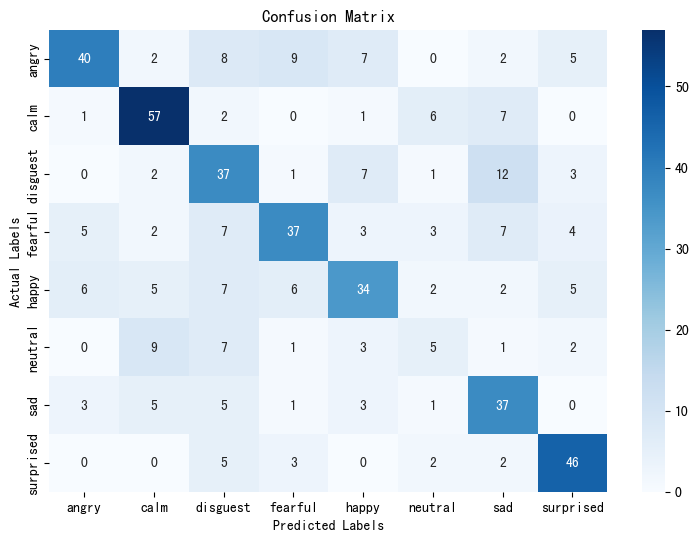

In [90]:
cm = pd.DataFrame(confusion_matrix(test_y_in, pred_y), index=[i for i in oh_encoder.categories_], columns=[i for i in oh_encoder.categories_])

fig, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(cm, linecolor='white', cmap='Blues', annot=True, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels')